In [2]:
#follow guidelines as to how to install packages from jupyter notebooks
import sys
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install matplotlib

#For details-> https://stackoverflow.com/questions/43567876/scipy-cannot-be-imported-in-jupyter-notebook

In [4]:
!{sys.executable} -m pip install -r requirements.txt

  Using cached Pillow-7.2.0.tar.gz (39.1 MB)
  Created wheel for Pillow: filename=Pillow-7.2.0-cp39-cp39-linux_x86_64.whl size=1066654 sha256=4a762d48b6fd271393fd025cb4f79a9ab2f8b79839deeba6f42431a3c8b6099a
  Stored in directory: /home/guest/.cache/pip/wheels/d2/4d/44/3fc103a77e1f7e6930a4a24994dbb5ea97eb14ff30c3cd0db6
Successfully built Pillow
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2


In [15]:
!{sys.executable} -m pip install tqdm

     |████████████████████████████████| 76 kB 3.4 MB/s eta 0:00:011


In [1]:
import matplotlib.pyplot as plt
import torch
import sys

In [2]:
#add a specific path for interpreter to search the RAFT files
sys.path.append('/home/guest/Documents')
#https://www.geeksforgeeks.org/sys-path-in-python/
sys.path

['/home/guest/Documents/SafeCam/ProjectCode',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/home/guest/.local/lib/python3.9/site-packages',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/guest/.local/lib/python3.9/site-packages/IPython/extensions',
 '/home/guest/.ipython',
 '/home/guest/Documents']

In [3]:
import cv2
#openCV
import numpy as np
from scipy.stats import kurtosis,skew
#scipy is the statistical elder brother of numpy
import os
#os helps in fetching files from different directories i.e. communication with the operating system
import pickle
#pickle helps in dumping content of large lists or dictionaries which is then stored in binary format 
#https://www.geeksforgeeks.org/understanding-python-pickling-example/
#https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python/899176

#https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
from timeit import default_timer as timer

#importing all relevant RAFT libraries
from raft.core.raft import RAFT
from raft.core.utils import flow_viz
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig

from PIL import Image

In [4]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [5]:
#OPTICAL FLOW MODEL INITIALIZATION AND PROCESSING
#Setting the configs for our RAFT deep learning model
config = RAFTConfig(
    dropout=0,
    alternate_corr=False,
    small=False,
    mixed_precision=False
)
#generating the model and displaying it
model = RAFT(config)
model

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [6]:
#setting device to run on cuda if nvidia gpu is present on pytorch for RAFT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
print(f'device: {device}')

#loading the pre-alloted weight
weights_path = '/home/guest/Documents/raft-sintel.pth'

ckpt = torch.load(weights_path, map_location=device)
#putting the whole model to the device(gpu or cuda)
model.to(device)
model.load_state_dict(ckpt)
#https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

device: cuda


<All keys matched successfully>

In [7]:
model.eval()

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [8]:
#OBJECT DETECTION MODEL INITIALIZATION AND PROCESSING
# returns a deep learning network using the yolov4 format
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')
# cv2.dnn.readNet=>https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422
# type net=Net object=>https://docs.opencv.org/3.4/db/d30/classcv_1_1dnn_1_1Net.html

In [9]:
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
#https://docs.opencv.org/3.4/db/d30/classcv_1_1dnn_1_1Net.html#a7f767df11386d39374db49cd8df8f59e
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
#https://docs.opencv.org/3.4/db/d30/classcv_1_1dnn_1_1Net.html#a9dddbefbc7f3defbe3eeb5dc3d3483f4

In [10]:
#verify that gpu is being used, 1 means 1 device is gpu-enabled
#https://stackoverflow.com/questions/61492452/how-to-check-if-opencv-is-using-gpu-or-not
count = cv2.cuda.getCudaEnabledDeviceCount()
print(count)

1


In [11]:
def load_image(imfile, device):
    img = np.array(Image.fromarray(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(device)


def viz(img1, img2, flo):
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    ax1.set_title('input image1')
    ax1.imshow(img1.astype(int))
    ax2.set_title('input image2')
    ax2.imshow(img2.astype(int))
    ax3.set_title('estimated optical flow')
    ax3.imshow(flo)
    plt.show()


In [19]:
def flow_res(file1,file2):
    #n_vis = 4
    
    image1 = load_image(file1, device)
    image2 = load_image(file2, device)
    
    padder = InputPadder(image1.shape)
    
    image1, image2 = padder.pad(image1, image2)
    
    #no backpropogation
    #https://datascience.stackexchange.com/questions/32651/what-is-the-use-of-torch-no-grad-in-pytorch
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
    #viz(image1, image2, flow_up)
    
    npa = flow_up.to('cpu').numpy()
    _,dims,y,x=npa.shape
    result=np.reshape(npa,(y,x,dims))
    
    return result


In [13]:
def write_file(filename,itemlist):
    #dumping contents of train vector onto file through pickle, which is more efficient
    pickle_out=open(filename,"wb")
    pickle.dump(itemlist,pickle_out)
    pickle_out.close()
    #https://pythonprogramming.net/python-pickle-module-save-objects-serialization/

In [14]:
def get_flow_patches(flow,boxes,idx):
    flows=[]
    if len(idx)>0:
        for i in idx.flatten():
            center_x,center_y,w,h=boxes[i]
            x=int(center_x-(w/2))
            y=int(center_y-(h/2))
            subx=0
            suby=0
            
            if x<0 or x>=flow.shape[1]:
                subx=x if x<0 else -1*x
                x=0 if x<0 else flow.shape[1]-1
            if y<0 or y>=flow.shape[0]:
                suby=y if y<0 else -1*y
                y=0 if y<0 else flow.shape[0]-1
            flows.append(flow[y:y+int(h)+suby,x:x+int(w)+subx,:])
    return flows

In [79]:
def frames_process2(frames_path, feature_matrix):
    frame_prev=None
    for img in np.sort(os.listdir(frames_path)):
        
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            #print(image_path)
            # for running optical flow algorithm we need previous frame as well
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                #imread->https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
                continue
            
            frame=cv2.imread(image_path)
            
            (height, width, _) = frame.shape
            
            #APPLYING OPTICAL FLOW ON THE FRAMES
            flow=flow_res(frame_prev,frame)
            # RUNNING YOLOv4 OBJECT DETECTION 
            # preprocessing the frame before feeding it to the neural net.
            # scale the pixel values to 1/255=>1/255
            # Resizing frame to (416,416) pixels as yolov4 architecture works on frame of that size.
            # No mean supplied to the three R,G,B channels=>(0,0,0)
            # OpenCV assumes images are in BGR channel order, thus we must swap the R and B channels of the original RGB frame=> swapRB=true
            # No cropping of the frame=>crop=False
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            # above parameters are needed for yolov4 detection!
            # cv2.dnn.blobFromImage=> creates processed 4-dimensional blob for use in our neural net.Further info=> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/

            # setting input to neural net
            net.setInput(blob)

            # net.getUnconnectedOutLayers(): It gives you the final layers number in the list from net.getLayerNames().
            output_layer_names = net.getUnconnectedOutLayersNames()

            # Runs forward pass to compute output of layer with name outputName
            layerOutputs = net.forward(output_layer_names)

            # model output=>https://stackoverflow.com/questions/57112038/yolo-v3-model-output-clarification-with-keras
            # There are 3 output layers in YOLO for 3 different resolutions of grid boxes over which object is detected(13,13)(26,26)(52,52)

            # boxes stores the location properties of detected objects
            # confidences stores the confidence score of detecting that object

            boxes = []
            confidences = []
            appearance = []

            # traversing through the 3 outputs at varying resolution

            for output in layerOutputs:
                for detection in output:
                    # detection holds the location(first 5 elements) and class probabilities(rest 80 elements)
                    scores = detection[5:]

                    # selecting the index of maximum class probabilty of total 80 classes and its probability value as well

                    class_id = np.argmax(scores)
                    confidence = scores[class_id]

                    # check to filter objects we are entirely sure belong to some class

                    if confidence > 0.6:

                        # Extracting the center coordinates of the bounding box
                        # we need to convert back to original dimensions thus multiply by width,height is important
                        # print(detection[0])

                        center_x = detection[0] * width
                        center_y = detection[1] * height

                        # extracting the width and height of bounding box

                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)

            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)

            # NMSBoxes=>https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

            i = 0
            if boxes != []:
                # extract flow ptached corresponsing to bounding box coordinates for detected objects
                flows=get_flow_patches(flow,boxes,indexes)
                
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        
                        #computing mean, variance, kurtosis and skew of the magnitude of velocity vectors
                        #motion metric
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        
                        #location metric
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        
                        #appearance[indexes.flatten()[i]]-> appearance metric
                        
                        #now creating feature vector for the object and appending feature vector of given object to feature matrix along with their weight
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        
                        i=i+1
               

            # updating previous frame

            frame_prev = frame
        
    cv2.destroyAllWindows()

In [80]:
def frames_process(frames_path, feature_matrix):
    frame_prev=None
    for img in np.sort(os.listdir(frames_path)):
        
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            #print(image_path)
            # for running optical flow algorithm we need previous frame as well
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                #imread->https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
                continue
            
            frame=cv2.imread(image_path)
            
            (height, width, _) = frame.shape
            
            #APPLYING OPTICAL FLOW ON THE FRAMES
            #Preprocessing to gray scale
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            #Dense optical flow algorithm
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            # RUNNING YOLOv4 OBJECT DETECTION 
            # preprocessing the frame before feeding it to the neural net.
            # scale the pixel values to 1/255=>1/255
            # Resizing frame to (416,416) pixels as yolov4 architecture works on frame of that size.
            # No mean supplied to the three R,G,B channels=>(0,0,0)
            # OpenCV assumes images are in BGR channel order, thus we must swap the R and B channels of the original RGB frame=> swapRB=true
            # No cropping of the frame=>crop=False
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            # above parameters are needed for yolov4 detection!
            # cv2.dnn.blobFromImage=> creates processed 4-dimensional blob for use in our neural net.Further info=> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/

            # setting input to neural net
            net.setInput(blob)

            # net.getUnconnectedOutLayers(): It gives you the final layers number in the list from net.getLayerNames().
            output_layer_names = net.getUnconnectedOutLayersNames()

            # Runs forward pass to compute output of layer with name outputName
            layerOutputs = net.forward(output_layer_names)

            # model output=>https://stackoverflow.com/questions/57112038/yolo-v3-model-output-clarification-with-keras
            # There are 3 output layers in YOLO for 3 different resolutions of grid boxes over which object is detected(13,13)(26,26)(52,52)

            # boxes stores the location properties of detected objects
            # confidences stores the confidence score of detecting that object

            boxes = []
            confidences = []
            appearance = []

            # traversing through the 3 outputs at varying resolution

            for output in layerOutputs:
                for detection in output:
                    # detection holds the location(first 5 elements) and class probabilities(rest 80 elements)
                    scores = detection[5:]

                    # selecting the index of maximum class probabilty of total 80 classes and its probability value as well

                    class_id = np.argmax(scores)
                    confidence = scores[class_id]

                    # check to filter objects we are entirely sure belong to some class

                    if confidence > 0.6:

                        # Extracting the center coordinates of the bounding box
                        # we need to convert back to original dimensions thus multiply by width,height is important
                        # print(detection[0])

                        center_x = detection[0] * width
                        center_y = detection[1] * height

                        # extracting the width and height of bounding box

                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)

            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)

            # NMSBoxes=>https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

            i = 0
            if boxes != []:
                # extract flow ptached corresponsing to bounding box coordinates for detected objects
                flows=get_flow_patches(flow,boxes,indexes)
                
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        
                        #computing mean, variance, kurtosis and skew of the magnitude of velocity vectors
                        #motion metric
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        
                        #location metric
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        
                        #appearance[indexes.flatten()[i]]-> appearance metric
                        
                        #now creating feature vector for the object and appending feature vector of given object to feature matrix along with their weight
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        
                        i=i+1
               

            # updating previous frame

            frame_prev = frame
        
    cv2.destroyAllWindows()

In [81]:
def vid_process(video_path,feature_matrix):
    cap=cv2.VideoCapture(video_path)
    if(cap.isOpened()==False): 
        print("Error connecting to camera")
        return -1
    ret,frame_prev=cap.read()
    if ret==False:
        print("Error loading frame")
        return
    while cap.isOpened():
        ret,frame=cap.read()
        if ret:
            height,width,_=frame.shape
            #start=timer()
            flow=flow_res(frame_prev,frame)
            #end=timer()
            #print("Frame completed in ",end-start, " seconds")
            
            blob=cv2.dnn.blobFromImage(frame,1/255,(416,416),(0,0,0),swapRB=True,crop=False)
            net.setInput(blob)
            output_layer_names=net.getUnconnectedOutLayersNames()
            layerOutputs=net.forward(output_layer_names)
            boxes=[]
            confidences=[]
            appearance=[]
            for output in layerOutputs:
                for detection in output:
                    scores=detection[5:]
                    class_id=np.argmax(scores)
                    confidence=scores[class_id]
                    if(confidence>0.6):
                        center_x=detection[0]*width
                        center_y=detection[1]*height
                        w=detection[2]*width
                        h=detection[3]*height
                        boxes.append([center_x,center_y,w,h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            
            indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.6,0.4)
            i=0
            if boxes!=[]:
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        i=i+1
            frame_prev=frame
            key=cv2.waitKey(1)
            if(key==27):
                break
        else:
            print("End of frames")
            return
    cap.release()
    cv2.destroyAllWindows()

In [82]:
def vid_process2(video_path,feature_matrix):
    #get video capture object for the camera for the specified video file 
    cap=cv2.VideoCapture(video_path)
    
    #Sometimes, cap may not have initialized the capture. 
    #You can check whether it is initialized or not by the method cap.isOpened().
    if(cap.isOpened()==False): 
        print("Error connecting to camera")
        return -1
    
    #for running optical flow algorithm we need previous frame as well
    ret,frame_prev=cap.read()
    #cap.read() returns a bool (True/False) which is stored in "ret" here. 
    #If the frame is read correctly, it will be True    
    
    if ret==False:
        print("Error loading frame")
        return
    while cap.isOpened():
        
        ret,frame=cap.read()
        
        if ret:
            #storing original frame dimensions
            height,width,_=frame.shape
            
            #APPLYING OPTICAL FLOW ON THE FRAMES
            #Preprocessing to gray scale
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            #Dense optical flow algorithm
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            #RUNNING YOLOv4 OBJECT DETECTION now
            #preprocessing the frame before feeding it to the neural net. 
            #scale the pixel values to 1/255=>1/255
            #Resizing frame to (416,416) pixels as yolov4 architecture works on frame of that size.
            #No mean supplied to the three R,G,B channels=>(0,0,0)
            #OpenCV assumes images are in BGR channel order, thus we must swap the R and B channels of the original RGB frame=> swapRB=true
            #No cropping of the frame=>crop=False
            blob=cv2.dnn.blobFromImage(frame,1/255,(416,416),(0,0,0),swapRB=True,crop=False)
            #above parameters are needed for yolov4 detection!
            #cv2.dnn.blobFromImage=> creates processed 4-dimensional blob for use in our neural net.Further info=> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
            
            #setting input to neural net
            net.setInput(blob)
            
            #net.getUnconnectedOutLayers(): It gives you the final layers number in the list from net.getLayerNames().
            output_layer_names=net.getUnconnectedOutLayersNames()
            
            #Runs forward pass to compute output of layer with name outputName
            layerOutputs=net.forward(output_layer_names)
            #model output=>https://stackoverflow.com/questions/57112038/yolo-v3-model-output-clarification-with-keras
            #There are 3 output layers in YOLO for 3 different resolutions of grid boxes over which object is detected(13,13)(26,26)(52,52)
            
            #boxes stores the location properties of detected objects
            #confidences stores the confidence score of detecting that object
            boxes=[]
            confidences=[]
            appearance=[]
            
            #traversing through the 3 outputs at varying resolution
            for output in layerOutputs:
                for detection in output:
                    #detection holds the location(first 5 elements) and class probabilities(rest 80 elements)
                    scores=detection[5:]
                    #print(scores)
                    #selecting the index of maximum class probabilty of total 80 classes and its probability value as well
                    class_id=np.argmax(scores)
                    confidence=scores[class_id]
                    #check to filter objects we are entirely sure belong to some class
                    if(confidence>0.6):
                        #Extracting the center coordinates of the bounding box
                        #we need to convert back to original dimensions thus multiply by width,height is important
                        #print(detection[0])
                        center_x=detection[0]*width
                        center_y=detection[1]*height
                        #extracting the width and height of bounding box
                        w=detection[2]*width
                        h=detection[3]*height
                        boxes.append([center_x,center_y,w,h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            
            indexes=cv2.dnn.NMSBoxes(boxes,confidences,0.6,0.4)
            #NMSBoxes=>https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c
            i=0
            if boxes!=[]:
                
                #extract flow area corresponsing to bounding box coordinates for detected objects
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        #computing mean, variance, kurtosis and skew of the magnitude of velocity vectors
                        #motion metric
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        #location metric
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        #appearance[indexes.flatten()[i]]-> appearance metric
                        #now creating feature vector for the object and appending feature vector of given object to feature matrix along with their weight
                        feature_matrix.append([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        i=i+1
                        
                        
            #updating previous frame            
            frame_prev=frame
            key=cv2.waitKey(1)
            
            #cv2.waitKey([delay])=>The function waitKey waits for a key event infinitely and the delay is in milliseconds. waitKey(0) means forever.
            #For more details=>https://stackoverflow.com/questions/57690899/how-cv2-waitkey1-0xff-ordq-works
            
            #if pressed key has ASCII value 27 i.e q
            if(key==27):
                break
            
            #if len(indexes)>0:
            #for i in indexes.flatten():                        
            
        else:
            print("End of frames")
            return
    cap.release()
    cv2.destroyAllWindows()

In [83]:
#TRAINING THE DATASET
train_vector=[]
#Getting the parent directory
parent_directory=os.path.dirname(os.getcwd())
#os.path.dirname() method in Python is used to get directory name from the specified path 
#i.e the directory that hold the current file
#Python method os.getcwd() returns current working directory of a process.
#For more info->https://www.geeksforgeeks.org/python-os-path-dirname-method/

#accesing the DATASET directory
direc=os.path.join(parent_directory,'Dataset')
#os.path.join-> https://www.geeksforgeeks.org/python-os-path-join-method/



print("Ped2 dataset")
#using the PEDESTRIAN training dataset
curr_direc=os.path.join(direc,'ped2','training','frames')
for subdirec in os.listdir(curr_direc):
    video_frames=os.path.join(curr_direc,subdirec)
    start=timer()
    frames_process(video_frames,train_vector)
    end=timer()
    print("Video completed in ",end-start, " seconds")


Ped2 dataset
Video completed in  9.731798859000264  seconds
Video completed in  10.134283232000598  seconds
Video completed in  12.055282129000261  seconds
Video completed in  14.471710972997244  seconds
Video completed in  14.504907258000458  seconds
Video completed in  14.477694615998189  seconds
Video completed in  12.141610586997558  seconds
Video completed in  12.120555994002643  seconds
Video completed in  12.097955307999655  seconds
Video completed in  14.601035939002031  seconds
Video completed in  12.259003314000438  seconds
Video completed in  12.14880359000017  seconds
Video completed in  12.106651910002256  seconds
Video completed in  14.486938856000052  seconds
Video completed in  14.614000396999472  seconds
Video completed in  14.505980231999274  seconds


In [ ]:
print("Avenue dataset")
#first using the AVENUE DATASET training videos 
curr_direc=os.path.join(direc,'Avenue Dataset','training_videos')
for filename in os.listdir(curr_direc):
    
    #os.listdir->https://www.geeksforgeeks.org/python-os-listdir-method/
    if filename.endswith(".avi"):
        print(filename)
        start=timer()
        vid_process(os.path.join(curr_direc,filename),train_vector)
        end=timer()
        print("Completed in ",end-start," seconds")

In [84]:
import numpy.matlib
def knndis(t,M2):
    #A vectorised implementation of finding KNN distance between a single point and the M2 matrix
    Mg=M2.shape[0]
    #this will replicate the feature vector of 't' Mg times columnwise. 
    #To subtract, transpose is taken to make it compatible
    #Sum is taken of each row
    
    dist=np.sqrt(np.sum((np.matlib.repmat(t,Mg,1) - M2)**2,1))
    #np.matlib.repmat->Repeat given matrix columnwise(mg) and rowise(1)-> https://numpy.org/doc/stable/reference/generated/numpy.matlib.repmat.html
    
    #sorting the distance according to ascending order
    np.sort(dist)
    
    #return the sum of first 10 neighbours i.e k=10
    return sum(dist[0:10])/10

In [85]:
#randomly shuffling the feature matrix
#print(train_vector)
np.random.shuffle(train_vector)
#random.shuffle-> shuffle contents of array inplace along the first axis of multi-array. 
#for more details->https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html

#converting to np array for later modifications
train_feature_matrix=np.array(train_vector)
print(train_feature_matrix.shape)


(18542, 87)


In [86]:
#Applying normalization
#np.min(matrix,axis) axis=0 implies apply minimum downwards i.e all rows in a column
g_min=np.min(train_feature_matrix,0)
g_max=np.max(train_feature_matrix,0)
print("g_min",g_min)
print("g_max",g_max)
for i in range(0,87):
    #normalization applied to all features where it is valid
    if g_min[i]!=g_max[i]:
        train_feature_matrix[:,i]=(train_feature_matrix[:,i]-g_min[i])/(g_max[i]-g_min[i])

g_min [ 2.45372489e-01  6.90652741e-05 -1.83496210e+00 -5.66435069e+00
  1.06003998e+00  3.91894197e+01  1.47841874e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0

In [87]:
#storing contents of train_vector
write_file('ped_list_normalized_farn.pickle',train_feature_matrix)

In [48]:
"""print("Shangai dataset")
#Using the SHANGAI TECH DATASET training videos
curr_direc=os.path.join(direc,'ShangaiTech_training','videos')
for filename in os.listdir(curr_direc):
    if filename.endswith(".avi"):
        vid_process(os.path.join(curr_direc,filename),train_vector)
"""

'print("Shangai dataset")\n#Using the SHANGAI TECH DATASET training videos\ncurr_direc=os.path.join(direc,\'ShangaiTech_training\',\'videos\')\nfor filename in os.listdir(curr_direc):\n    if filename.endswith(".avi"):\n        vid_process(os.path.join(curr_direc,filename),train_vector)\n'

In [88]:
#opening the contents of the pickle file in reading mode
pickle_in=open("ped_list_normalized_farn.pickle","rb")
#loading the stored np array
train_feature_matrix=pickle.load(pickle_in)
np.random.shuffle(train_feature_matrix)
print(train_feature_matrix[0:100])

[[0.45001973 0.06116519 0.07912493 ... 0.         0.         0.        ]
 [0.47358065 0.10190713 0.23714434 ... 0.         0.         0.        ]
 [0.25398416 0.01733853 0.12979879 ... 0.         0.         0.        ]
 ...
 [0.3219725  0.26192131 0.09048627 ... 0.         0.         0.        ]
 [0.4608013  0.04890629 0.09263801 ... 0.         0.         0.        ]
 [0.38449323 0.0358575  0.03527002 ... 0.         0.         0.        ]]


In [89]:
#Keeps track of di for all object i. 
errors=list()

#as given in the paper, split the training dataset into M1 and M2. Here 20% of training dataset goes to M1. 
p1=int(train_feature_matrix.shape[0]*0.2)
p2=train_feature_matrix.shape[0]-p1

M1=train_feature_matrix[0:p1]
M2=train_feature_matrix[p1:None]

#Finding the KNN distance for all the points in M1
for i in range(p1):
    errors.append(knndis(M1[i],M2)) 
print(errors)

[0.5072769243221751, 0.6160909308873419, 0.4648498611760504, 0.5012320527793797, 0.4256241929669435, 0.5060101756569536, 0.5432486684626208, 0.3603806960970911, 0.47304530051870525, 0.5517836508998993, 0.4766168424801962, 0.39547933422122117, 0.39603278854631363, 0.39831122553961956, 0.4187736182537852, 0.3756731371469595, 0.5211220440995499, 0.4995580463815272, 0.5496202584630405, 0.5805881560381246, 0.4370699305105137, 0.45824346665248267, 0.3929622129555597, 0.36099590347231403, 0.46908522758267246, 0.4156954980897368, 0.5120428017776768, 0.5877075492867582, 0.4537690930074757, 0.6129997588127035, 0.39906020972956147, 0.53545174284324, 0.3804597838774254, 0.451882601504234, 0.4433045819896579, 0.506308900407782, 0.5990510788787831, 0.41287826083016876, 0.436877405141631, 0.3933615551915196, 0.4708156478900172, 0.41960366944734917, 0.4676451334850872, 0.40893177242592876, 0.503950941107562, 0.5579844560052292, 0.5196281861816612, 0.40722792331791535, 0.4731756475321511, 0.43083824758

In [90]:
print(len(errors))

3708


In [91]:
#Using base thresold as one where 90% of KNN distance is lesser
Base_lm = np.sort(errors)[int(len(errors)*0.9)]
print("Base score",Base_lm)
print("Lowest knn distance",np.sort(errors)[0])
print("Highest knn distance",np.sort(errors)[len(errors)-1])


Base score 0.5775635543055787
Lowest knn distance 0.33327663277965713
Highest knn distance 1.3124043730423627


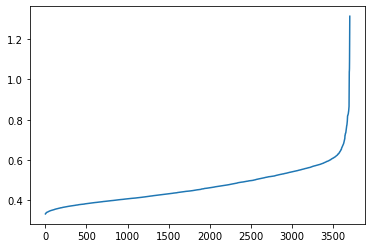

In [92]:
plt.plot(np.sort(errors)[0:len(errors)])

In [54]:
#Storing this variable for other jupyter notebooks to share, or for future use
%store Base_lm
%store g_min
%store g_max
%store M2
#For more details->https://stackoverflow.com/questions/35935670/share-variables-between-different-jupyter-notebooks

Stored 'Base_lm' (float64)
Stored 'g_min' (ndarray)
Stored 'g_max' (ndarray)
Stored 'M2' (ndarray)


In [56]:
threshold=np.sort(errors)[len(errors)-1]
%store threshold

Stored 'threshold' (float64)


In [67]:
print(threshold)

1.4087832797188793


In [95]:
def frames_process_test(frames_path,AV2):
    St=[0]
    num=0
    frame_prev=None
    fine_tune=False
    count=0
    for img in np.sort(os.listdir(frames_path)):
        if img.endswith(".jpg"):
            image_path=os.path.join(frames_path,img)
            if frame_prev is None:
                frame_prev=cv2.imread(image_path)
                continue
            frame=cv2.imread(image_path)
            (height, width, _) = frame.shape
            prvs=cv2.cvtColor(frame_prev,cv2.COLOR_BGR2GRAY)
            curr=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            flow=cv2.calcOpticalFlowFarneback(prvs, curr, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            blob = cv2.dnn.blobFromImage(frame,1 / 255,(416, 416),(0, 0, 0),swapRB=True,crop=False)
            net.setInput(blob)
            output_layer_names = net.getUnconnectedOutLayersNames()
            layerOutputs = net.forward(output_layer_names)
            boxes = []
            confidences = []
            appearance = []
            for output in layerOutputs:
                for detection in output:
                    scores = detection[5:]
                    class_id = np.argmax(scores)
                    confidence = scores[class_id]
                    if confidence > 0.6:
                        center_x = detection[0] * width
                        center_y = detection[1] * height
                        w = detection[2] * width
                        h = detection[3] * height
                        boxes.append([center_x, center_y, w, h])
                        confidences.append(float(confidence))
                        appearance.append(scores)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.6, 0.4)
            i = 0
            t=list()
            if boxes != []:
                flows=get_flow_patches(flow,boxes,indexes)
                if flows!=[]:
                    for flow_patch in flows:
                        mag, _ = cv2.cartToPolar(flow_patch[..., 0], flow_patch[..., 1])
                        mean=np.mean(mag)
                        variance=np.var(mag)
                        kurtosis_=kurtosis(mag,None)
                        skew_=skew(mag,None)
                        cx,cy,wi,hi=boxes[indexes.flatten()[i]]
                        test_matrix=np.array([mean,variance,kurtosis_,skew_]+[0.4*cx,0.4*cy,0.4*wi*hi]+list(0.9*appearance[indexes.flatten()[i]]))
                        for j in range(0,87):
                            #normalization applied to all features where it is valid
                            if g_min[j]!=g_max[j]:
                                test_matrix[j]=(test_matrix[j]-g_min[j])/(g_max[j]-g_min[j])
                        t.append(knndis(test_matrix,M2))
                        #print(t)
                        i=i+1
            d=(np.max(t)-Base_lm)
            St.append(np.max((0,St[num]+d)))
            #print(d," ",St)
            if fine_tune==True and num > 5:
                if St[num+1] - St[num] <=0:
                    if St[num] - St[num-1] <=0:
                        if St[num-1] - St[num-2] <=0:
                            St[num+1] = 0
                            fine_tune=False
            if(St[num+1]>threshold):
                fine_tune=True
            #print(St[num+1])
            '''if fine_tune==True:
                if(np.max((0,St[num]+d))>St[num]):
                    St.append(np.max((0,St[num]+d)))
                else:
                    
            else:
                fine_tune=False
                count=0
                St.append(np.max(0,d))
            
            if St[num+1]>threshold:
                fine_tune=True
            
            print(St[num+1])'''
            frame_prev = frame
            num=num+1
    #idx=np.where(np.array(vid)>threshold)
    cv2.destroyAllWindows()
    plt.plot((St-np.min(St)/(np.max(St)-np.min(St))))
    plt.show()
    AV2.append((St-np.min(St)/(np.max(St)-np.min(St))))

Ped2 dataset


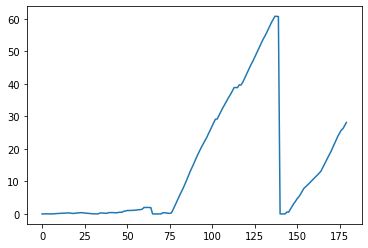

Video completed in  25.88406823100013  seconds


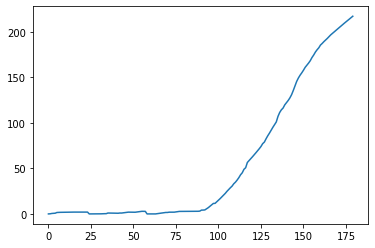

Video completed in  25.698490735998348  seconds


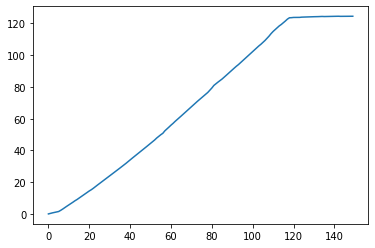

Video completed in  23.080281546997867  seconds


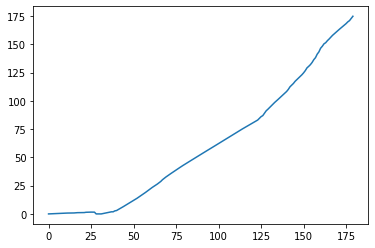

Video completed in  26.106047313998715  seconds


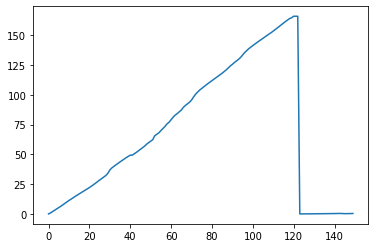

Video completed in  20.57507310299843  seconds


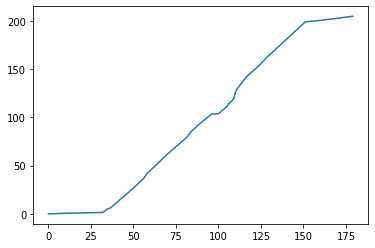

Video completed in  27.360539654000604  seconds


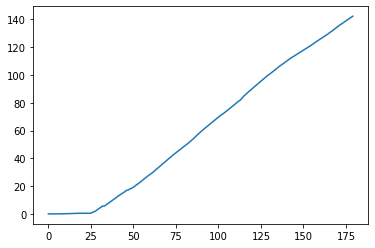

Video completed in  27.452698520999547  seconds


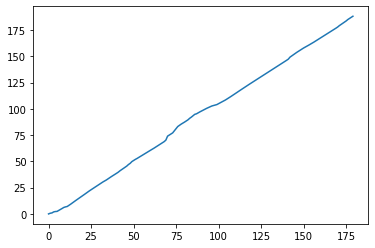

Video completed in  27.539518294001027  seconds


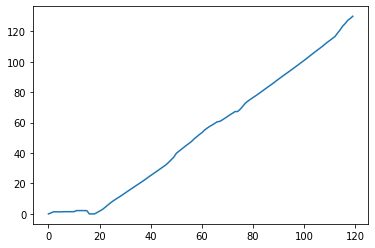

Video completed in  18.674621142999968  seconds


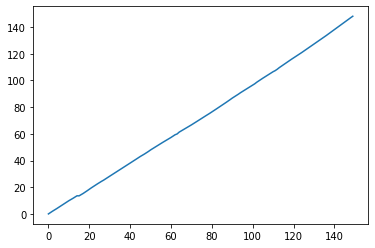

Video completed in  21.312578758999734  seconds


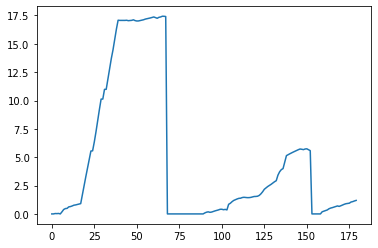

Video completed in  25.508689475998835  seconds


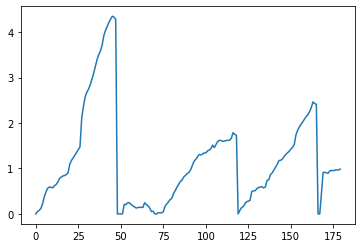

Video completed in  25.659321927003475  seconds


In [96]:
AV2=list()
print("Ped2 dataset")
#using the PEDESTRIAN training dataset
curr_direc=os.path.join(direc,'ped2','testing','frames')
for subdirec in np.sort(os.listdir(curr_direc)):
    video_frames=os.path.join(curr_direc,subdirec)
    start=timer()
    frames_process_test(video_frames,AV2)
    end=timer()
    print("Video completed in ",end-start, " seconds")
